In [1]:
# Copyright 2020 by Emilio Cabrera
# All rights reserved.



The MIT License (MIT)

Copyright (c) 2020 Emilio Cabrera

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
#from timeit import default_timer as timer
#from numba import jit #Numba doesn't seem to work in the presence if inherit classes
#http://numba.pydata.org/numba-doc/0.6/doc/extension_types.html

In [2]:
#I am creating a separate class for the binomial tree. The reasons are two:
#1. Some greeks will require pricing twice the derivative (vega, rho, theta)
#2. Thinking forward in terms of portfolio, one binomial tree per underlying asset should suffice
class BinTree:
    
    def __init__(self, time_to_maturity, spot, rf, rd, volatility, steps):
        
        
        self.time_to_maturity0 = time_to_maturity #Double years to maturity
        self.spot0 = spot #Double spot price
        self.rf0 = rf #Double foreign interest rate or dividend rate
        self.rd0 = rd #Double risk free rate or domestic rate
        self.volatility0 = volatility #Volatility
        self.steps0 = steps
        self.up_factor0 = np.exp(self.volatility0 * np.sqrt(self.time_to_maturity0/self.steps0))
        self.down_factor0 = 1/self.up_factor0
        self.tree_matrix0 = np.matrix(np.zeros(shape = (self.steps0, self.steps0)))
        self.tree_matrix0[0,0] = self.spot0
        
        
    #@jit(nopython=True) #Make it faster
    def binomial_tree(self):#Binomial tree to be used for pricing
        #self.N = steps
        for i in range(self.steps0):
            for j in range(self.steps0):
                if j > 0 and i == j:
                    self.tree_matrix0[i,j] = self.tree_matrix0[i-1,j-1]*self.down_factor0
                if j > i:
                    self.tree_matrix0[i,j] = self.tree_matrix0[i,j-1]*self.up_factor0
        return self.tree_matrix0
    

In [84]:
class MCEngine:
    
    def __init__(self, time_to_maturity, spot, rf, rd, volatility, steps):
        
        
        self.time_to_maturity1 = time_to_maturity #Double years to maturity
        self.spot1 = spot #Double spot price
        self.rf1 = rf #Double foreign interest rate or dividend rate
        self.rd1 = rd #Double risk free rate or domestic rate
        self.volatility1 = volatility #Volatility
        self.steps1 = steps
        self.dt1 = self.time_to_maturity1/self.steps1
        self.paths1 = np.ones(shape = (10000, self.steps1))
        self.paths1[:,0] = self.paths1[:,0]*self.spot1
        
        self.stress = 0.001
        
        #The simulations for the greeks have to be created within the class 
        self.paths_delta = np.ones(shape = (10000, self.steps1))
        self.paths_delta[:,0] = self.paths_delta[:,0]*(self.spot1 + self.stress)
        
        self.paths_gamma = np.ones(shape = (10000, self.steps1))
        self.paths_gamma[:,0] = self.paths_gamma[:,0]*(self.spot1 - self.stress)
        
        self.sim1 = np.random.normal(0,1,size = (10000, self.steps1 - 1))
        
    def path_generator(self):
        for i in range(self.steps1-1):
            self.paths1[:,i+1] = self.paths1[:,i]*np.exp((self.rd1 - self.rf1 - 0.5*self.volatility1**2)*self.dt1 + 
                                                         self.volatility1*self.sim1[:,i]*np.sqrt(self.dt1))
        return self.paths1
    
    def delta_path_generator(self):
        for i in range(self.steps1-1):
            self.paths_delta[:,i+1] = self.paths_delta[:,i]*np.exp((self.rd1 - self.rf1 - 0.5*self.volatility1**2)*self.dt1 + 
                                                         self.volatility1*self.sim1[:,i]*np.sqrt(self.dt1))
        return self.paths_delta
    
    def gamma_path_generator(self): #Based on finite differences method
        for i in range(self.steps1-1):
            self.paths_gamma[:,i+1] = self.paths_gamma[:,i]*np.exp((self.rd1 - self.rf1 - 0.5*self.volatility1**2)*self.dt1 + 
                                                         self.volatility1*self.sim1[:,i]*np.sqrt(self.dt1))
        return self.paths_gamma
        
    
        
    
    
    
    

In [85]:
class option_payoff():
    
    def __init__(self):
        pass
        
    def compute_payoff(self, stock_price, strike, call_put):
        self.stock_price = stock_price
        self.strike2 = strike
        if call_put == "Call" or call_put == "call" or call_put == "C" or call_put == "c":
            return np.maximum(0,self.stock_price - self.strike2)
        elif call_put == "Put" or call_put == "put" or call_put == "P" or call_put == "p":
             return np.maximum(0,-self.stock_price + self.strike2)
        else:
            pass
    

In [96]:
class OptionsPricingCS(BinTree, MCEngine, option_payoff):#Options pricing close solution and simulations
    
    def __init__(self, call_put, excercise_type, strike, time_to_maturity, spot, rf, rd, volatility):
        self.call_put = call_put #String call or put # Let's move it out
        self.excercise_type = excercise_type #String American or European
        self.strike = strike #Double strike price
        self.time_to_maturity = time_to_maturity #Double years to maturity
        self.spot = spot #Double spot price
        self.rf = rf #Double foreign interest rate or dividend rate
        self.rd = rd #Double risk free rate or domestic rate
        self.volatility = volatility #Volatility
        self.Nd1 = 0
        self.Nd2 = 0
        self.steps = 100
        BinTree.__init__(self,time_to_maturity = self.time_to_maturity,
                         spot = self.spot, rf = self.rf, rd = self.rd,
                         volatility = self.volatility,steps=self.steps )
        MCEngine.__init__(self,time_to_maturity = self.time_to_maturity,
                          spot = self.spot, rf = self.rf, rd = self.rd,
                          volatility = self.volatility, steps = self.steps)
        option_payoff.__init__(self)
        
    def payoff2(self, spot):
        return self.compute_payoff(spot,self.strike,self.call_put)
        
    def european_call_BS(self): #Black-Scholes-Merton Formula for Vanilla European Call
        self.d1 = (np.log(self.spot/ self.strike) + 
                   (self.rd - self.rf + 0.5 * self.volatility**2)*self.time_to_maturity) / (self.volatility*np.sqrt(self.time_to_maturity))
        self.d2 = self.d1 - self.volatility*np.sqrt(self.time_to_maturity)
        self.N_d1 = norm.cdf(self.d1)
        self.N_d2 = norm.cdf(self.d2)
        self.delta = np.exp(-self.rf*self.time_to_maturity)*self.N_d1
        
        self.call_pv = self.spot*self.delta - self.strike*np.exp(-self.rd*self.time_to_maturity)*self.N_d2
        
        self.gamma = norm.pdf(self.d1)/(self.spot*self.volatility*np.sqrt(self.time_to_maturity))
        self.vega = norm.pdf(self.d1)*(self.spot*np.sqrt(self.time_to_maturity))/100
        self.theta = -norm.pdf(self.d1)*(self.spot)*(self.volatility)/(2*np.sqrt(self.time_to_maturity)) - self.rd*self.strike*np.exp(-self.rd*self.time_to_maturity)*self.N_d2 + self.rf*self.spot*np.exp(-self.rf*self.time_to_maturity)*self.N_d1
        self.rho = self.strike*np.exp(-self.rd*self.time_to_maturity)*self.N_d2/100
        return self.call_pv, self.delta, self.gamma, self.vega, self.theta, self.rho                     
        
    def european_put_BS(self): #Black-Scholes-Merton Formula for Vanilla European Call
        self.d1 = (np.log(self.spot/ self.strike) + 
                   (self.rd - self.rf + 0.5 * self.volatility**2)*self.time_to_maturity) / (self.volatility*np.sqrt(self.time_to_maturity))
        self.d2 = self.d1 - self.volatility*np.sqrt(self.time_to_maturity)
        self.N_d1 = norm.cdf(-self.d1)
        self.N_d2 = norm.cdf(-self.d2)
        self.delta = - np.exp(-self.rf*self.time_to_maturity)*self.N_d1
        
        self.put_pv = + self.spot*self.delta + self.strike*np.exp(-self.rd*self.time_to_maturity)*self.N_d2
        
        self.gamma = norm.pdf(self.d1)/(self.spot*self.volatility*np.sqrt(self.time_to_maturity))
        self.vega = norm.pdf(self.d1)*(self.spot*np.sqrt(self.time_to_maturity))/100
        self.theta = -norm.pdf(self.d1)*(self.spot)*(self.volatility)/(2*np.sqrt(self.time_to_maturity)) + self.rd*self.strike*np.exp(-self.rd*self.time_to_maturity)*self.N_d2 + + self.rf*self.spot*np.exp(-self.rf*self.time_to_maturity)*(1 - self.N_d1)
        self.rho = self.strike*np.exp(-self.rd*self.time_to_maturity)*(1 - self.N_d2)/100
        return self.put_pv, self.delta, self.gamma, self.vega, self.theta, self.rho
    
    def european_put_call_parity(self):
        return self.european_call_BS()[0] - self.european_put_BS()[0]
    
    
      
        
    #Note on Numba: the first invocation of the function will actually make it slower
    #subsequent invocations will be faster
    #@jit(nopython=True) #Make it faster
    def european_call_binomial(self, tree , return_tree = False):#European call with binomial tree
        self.call_put = "Call"
        self.tree = tree #self.binomial_tree(steps = N)
        #self.steps = N
        self.up_factor = np.exp(self.volatility * np.sqrt(self.time_to_maturity/self.steps))
        self.down_factor = 1/self.up_factor
        self.pu = (np.exp((self.rd - self.rf)*self.time_to_maturity/self.steps) - self.down_factor)/(self.up_factor - self.down_factor)
        self.pd = 1 - self.pu
        self.df = np.exp(-self.rd*self.time_to_maturity/self.steps)
        self.tree_matrix = np.matrix(np.zeros(shape = (self.steps, self.steps)))
        #self.tree_matrix[:,self.steps - 1] = np.maximum(self.tree[:,self.steps - 1] - self.strike,0)
        
        #Try the map instead of the max function - we need to make a decision about over-riding the option type May 4th 2020
        x1 = self.binomial_tree()[:,self.steps - 1]
        result = np.array(list(map(self.payoff2, x1)))
        self.tree_matrix[:,self.steps - 1] = result.reshape(self.steps, 1)
        
        for j in range(self.steps - 2, -1, -1):
            for i in range(self.steps -  1):
                if j>=i:
                    self.tree_matrix[i,j] = (self.pu*self.tree_matrix[i,j+1] + self.pd*self.tree_matrix[i+1,j+1])*self.df
                else:
                    self.tree_matrix[i,j] = 0
        
        self.delta = (self.tree_matrix[0,1] - self.tree_matrix[1,1])/(self.tree[0,1] - self.tree[1,1])
        
        self.delta2 = (self.tree_matrix[0,2] - self.tree_matrix[1,2])/(self.tree[0,2] - self.tree[1,2])       
        self.delta1 = (self.tree_matrix[1,2] - self.tree_matrix[2,2])/(self.tree[1,2] - self.tree[2,2])   
        self.h = (self.tree[0,2] - self.tree[2,2])*0.5
        self.gamma = (self.delta2 - self.delta1)/self.h
        
        if return_tree == True:
            return self.tree_matrix
        else:
            return self.tree_matrix[0,0], self.delta, self.gamma
    
    #@jit(nopython=True) #Make it faster
    def european_put_binomial(self, tree , return_tree=False):#European put with binomial tree
        self.call_put = "Put"
        self.tree = tree #self.binomial_tree(steps = N)
        #self.steps = N
        self.up_factor = np.exp(self.volatility * np.sqrt(self.time_to_maturity/self.steps))
        self.down_factor = 1/self.up_factor
        self.pu = (np.exp((self.rd - self.rf)*self.time_to_maturity/self.steps) - self.down_factor)/(self.up_factor - self.down_factor)
        self.pd = 1 - self.pu
        self.df = np.exp(-self.rd*self.time_to_maturity/self.steps)
        self.tree_matrix = np.matrix(np.zeros(shape = (self.steps, self.steps)))
        
        #Try the map instead of the max function - we need to make a decision about over-riding the option type May 4th 2020
        x1 = self.binomial_tree()[:,self.steps - 1]
        result = np.array(list(map(self.payoff2, x1)))
        self.tree_matrix[:,self.steps - 1] = result.reshape(self.steps, 1)
        
        
        #self.tree_matrix[:,self.steps - 1] = np.maximum(- self.tree[:,self.steps - 1] + self.strike,0)
        
        for j in range(self.steps - 2, -1, -1):
            for i in range(self.steps -  1):
                if j>=i:
                    self.tree_matrix[i,j] = (self.pu*self.tree_matrix[i,j+1] + self.pd*self.tree_matrix[i+1,j+1])*self.df
                else:
                    self.tree_matrix[i,j] = 0
                
        self.delta = (self.tree_matrix[0,1] - self.tree_matrix[1,1])/(self.tree[0,1] - self.tree[1,1])       
        
        self.delta2 = (self.tree_matrix[0,2] - self.tree_matrix[1,2])/(self.tree[0,2] - self.tree[1,2])       
        self.delta1 = (self.tree_matrix[1,2] - self.tree_matrix[2,2])/(self.tree[1,2] - self.tree[2,2])
        self.h = (self.tree[0,2] - self.tree[2,2])*0.5
        self.gamma = (self.delta2 - self.delta1)/self.h
        
        if return_tree == True:
            return self.tree_matrix
        else:
            return self.tree_matrix[0,0], self.delta, self.gamma
        
    #European Call with MC simulation
    def european_call_MC(self,return_payoffs = False):
        self.call_put = "Call" #Fixing for the payoff class
        n = len(self.path_generator()[:,self.steps - 1])
        
        #Update tomorrow to make more slim! 5 May 2020
        #strike_vector = np.ones(n)*self.strike
        
        #self.payoff =  np.maximum(self.path_generator()[:,self.steps - 1] - strike_vector,0)*np.exp(-self.rd*self.time_to_maturity) 
        #self.payoff2 =  np.maximum(self.delta_path_generator()[:,self.steps - 1] - strike_vector,0)*np.exp(-self.rd*self.time_to_maturity) 
        #self.payoff3 =  np.maximum(self.gamma_path_generator()[:,self.steps - 1] - strike_vector,0)*np.exp(-self.rd*self.time_to_maturity) 
        
        #Payoff to compute with spot
        x1 = self.path_generator()[:,self.steps - 1]
        result = np.array(list(map(self.payoff2, x1)))
        payoff = result*np.exp(-self.rd*self.time_to_maturity)#result.reshape(self.steps, 1)
        
        #Try the map instead of the max function - we need to make a decision about over-riding the option type May 4th 2020
        x2 = self.delta_path_generator()[:,self.steps - 1]
        result2 = np.array(list(map(self.payoff2, x2)))
        payoff2 = result2*np.exp(-self.rd*self.time_to_maturity)#.reshape(self.steps, 1)
        
        #Try the map instead of the max function - we need to make a decision about over-riding the option type May 4th 2020
        x3 = self.gamma_path_generator()[:,self.steps - 1]
        result3 = np.array(list(map(self.payoff2, x3)))
        payoff3 = result3*np.exp(-self.rd*self.time_to_maturity)#.reshape(self.steps, 1)
        
        
        self.delta =  (np.mean(payoff2) - np.mean(payoff))/self.stress
        #Finite difference methods
        self.gamma = (np.mean(payoff2) - 2*np.mean(payoff) + np.mean(payoff3))/(self.stress**2)
        
        if return_payoffs == False:
            return np.mean(payoff), self.delta, self.gamma
        else:
            return self.payoff
    
    #European Put with MC simulation
    def european_put_MC(self,return_payoffs = False):
        self.call_put = "Put" #Fixing for the payoff class
        n = len(self.path_generator()[:,self.steps - 1])
        
        #strike_vector = np.ones(n)*self.strike
        #self.payoff =  np.maximum(-self.path_generator()[:,self.steps - 1] + strike_vector,0)*np.exp(-self.rd*self.time_to_maturity) 
        #self.payoff2 =  np.maximum(-self.delta_path_generator()[:,self.steps - 1] + strike_vector,0)*np.exp(-self.rd*self.time_to_maturity) 
        #self.payoff3 =  np.maximum(-self.gamma_path_generator()[:,self.steps - 1] + strike_vector,0)*np.exp(-self.rd*self.time_to_maturity) 
        
        #Payoff to compute with spot
        x1 = self.path_generator()[:,self.steps - 1]
        result = np.array(list(map(self.payoff2, x1)))
        payoff = result*np.exp(-self.rd*self.time_to_maturity)#result.reshape(self.steps, 1)
        
        #Try the map instead of the max function - we need to make a decision about over-riding the option type May 4th 2020
        x2 = self.delta_path_generator()[:,self.steps - 1]
        result2 = np.array(list(map(self.payoff2, x2)))
        payoff2 = result2*np.exp(-self.rd*self.time_to_maturity)#.reshape(self.steps, 1)
        
        #Try the map instead of the max function - we need to make a decision about over-riding the option type May 4th 2020
        x3 = self.gamma_path_generator()[:,self.steps - 1]
        result3 = np.array(list(map(self.payoff2, x3)))
        payoff3 = result3*np.exp(-self.rd*self.time_to_maturity)#.reshape(self.steps, 1)
        
        
        self.delta =  (np.mean(payoff2) - np.mean(payoff))/self.stress
        #Finite difference methods
        self.gamma = (np.mean(payoff2) - 2*np.mean(payoff) + np.mean(payoff3))/(self.stress**2)
        
        if return_payoffs == False:
            return np.mean(payoff), self.delta, self.gamma
        else:
            return self.payoff
    
        
    
    #American Call with binomial tree
    def american_call_binomial(self, tree ,return_tree=False):
        self.call_put = "Call" #Fixing for the payoff class
        self.tree = tree #self.binomial_tree(steps = N)
        #self.steps = N
        self.up_factor = np.exp(self.volatility * np.sqrt(self.time_to_maturity/self.steps))
        self.down_factor = 1/self.up_factor
        self.pu = (np.exp((self.rd - self.rf)*self.time_to_maturity/self.steps) - self.down_factor)/(self.up_factor - self.down_factor)
        self.pd = 1 - self.pu
        self.df = np.exp(-self.rd*self.time_to_maturity/self.steps)
        self.tree_matrix = np.matrix(np.zeros(shape = (self.steps, self.steps)))
        #self.tree_matrix[:,self.steps - 1] = np.maximum(self.tree[:,self.steps - 1] - self.strike,0)
        
        #Try the map instead of the max function - we need to make a decision about over-riding the option type May 4th 2020
        x1 = self.binomial_tree()[:,self.steps - 1]
        result = np.array(list(map(self.payoff2, x1)))
        self.tree_matrix[:,self.steps - 1] = result.reshape(self.steps, 1)
        
        
        for j in range(self.steps - 2, -1, -1):
            for i in range(self.steps -  1):
                if j>=i:
                    x1 = (self.pu*self.tree_matrix[i,j+1] + self.pd*self.tree_matrix[i+1,j+1])
                    x2 = self.tree[i,j] - self.strike
                    self.tree_matrix[i,j] = self.df * np.maximum(x1, x2)
                else:
                    self.tree_matrix[i,j] = 0
        
        self.delta = (self.tree_matrix[0,1] - self.tree_matrix[1,1])/(self.tree[0,1] - self.tree[1,1])
        
        self.delta2 = (self.tree_matrix[0,2] - self.tree_matrix[1,2])/(self.tree[0,2] - self.tree[1,2])       
        self.delta1 = (self.tree_matrix[1,2] - self.tree_matrix[2,2])/(self.tree[1,2] - self.tree[2,2])   
        self.h = (self.tree[0,2] - self.tree[2,2])*0.5
        self.gamma = (self.delta2 - self.delta1)/self.h
        
        if return_tree == True:
            return self.tree_matrix
        else:
            return self.tree_matrix[0,0], self.delta, self.gamma
        
    
    #American Put with binomial tree
    def american_put_binomial(self, tree , return_tree=False):
        self.call_put = "Put" #Fixed for the payoff class
        self.tree = tree #self.binomial_tree(steps = N)
        #self.steps = N
        self.up_factor = np.exp(self.volatility * np.sqrt(self.time_to_maturity/self.steps))
        self.down_factor = 1/self.up_factor
        self.pu = (np.exp((self.rd - self.rf)*self.time_to_maturity/self.steps) - self.down_factor)/(self.up_factor - self.down_factor)
        self.pd = 1 - self.pu
        self.df = np.exp(-self.rd*self.time_to_maturity/self.steps)
        self.tree_matrix = np.matrix(np.zeros(shape = (self.steps, self.steps)))
        #self.tree_matrix[:,self.steps - 1] = np.maximum(- self.tree[:,self.steps - 1] + self.strike,0)
        
        #Try the map instead of the max function - we need to make a decision about over-riding the option type May 4th 2020
        x1 = self.binomial_tree()[:,self.steps - 1]
        result = np.array(list(map(self.payoff2, x1)))
        self.tree_matrix[:,self.steps - 1] = result.reshape(self.steps, 1)
        
        
        for j in range(self.steps - 2, -1, -1):
            for i in range(self.steps -  1):
                if j>=i:
                    x1 = (self.pu*self.tree_matrix[i,j+1] + self.pd*self.tree_matrix[i+1,j+1])
                    x2 = -self.tree[i,j] + self.strike
                    self.tree_matrix[i,j] = self.df * np.maximum(x1, x2)
                else:
                    self.tree_matrix[i,j] = 0
        
        self.delta = (self.tree_matrix[0,1] - self.tree_matrix[1,1])/(self.tree[0,1] - self.tree[1,1])
        
        self.delta2 = (self.tree_matrix[0,2] - self.tree_matrix[1,2])/(self.tree[0,2] - self.tree[1,2])       
        self.delta1 = (self.tree_matrix[1,2] - self.tree_matrix[2,2])/(self.tree[1,2] - self.tree[2,2])   
        self.h = (self.tree[0,2] - self.tree[2,2])*0.5
        self.gamma = (self.delta2 - self.delta1)/self.h
        
        if return_tree == True:
            return self.tree_matrix
        else:
            return self.tree_matrix[0,0], self.delta, self.gamma
        
    
    #@jit(nopython=True) #Make it faster
    def european_put_call_parity_bin(self):
        tree = self.binomial_tree()
        return self.european_call_binomial(tree, return_tree=False)[0] - self.european_put_binomial( tree, return_tree = False)[0]
    
    #Plotting the tree for the stock or the option
    #This charts are analogous to the binomial trees themselves but, capturing the relation between stock and option
    #Through colors
    def eur_call_bin_plot(self, Stock_Option = True):
        m1 = self.binomial_tree() #Stock tree
        m2 = self.european_call_binomial(m1,return_tree = True) #Option payoff tree
        fig = plt.figure(figsize=[10, 10])
        
        if Stock_Option == True:
            for i in range(self.steps-1):
                plt.scatter(x = np.ones(len(m1[:,i]))*i/100, y = np.round(m1[:,i],4), c = np.array(m2[:,i]), cmap = "Oranges")
                plt.xlabel("Time Step")
                plt.ylabel("Stock price")
                plt.title("Color shade indicates the European call option value")
            plt.show()
        else:
            for i in range(self.steps-1):
                plt.scatter(x = np.ones(len(m2[:,i]))*i/100, y = np.round(m2[:,i],4), c = np.array(m1[:,i]), cmap = "Blues")
                plt.xlabel("Time Step")
                plt.ylabel("European Call Option Price")
                plt.title("Color shade indicates the Stock price")
            plt.show()
            
    
    def eur_put_bin_plot(self, Stock_Option = True):
        m1 = self.binomial_tree() #Stock tree
        m2 = self.european_put_binomial(m1,return_tree = True) #Option payoff tree
        fig = plt.figure(figsize=[10, 10])
        
        if Stock_Option == True:
            for i in range(self.steps-1):
                plt.scatter(x = np.ones(len(m1[:,i]))*i/100, y = np.round(m1[:,i],4), c = np.array(m2[:,i]), cmap = "Oranges")
                plt.xlabel("Time Step")
                plt.ylabel("Stock price")
                plt.title("Color shade indicates the European put option value")
            plt.show()
        else:
            for i in range(self.steps-1):
                plt.scatter(x = np.ones(len(m2[:,i]))*i/100, y = np.round(m2[:,i],4), c = np.array(m1[:,i]), cmap = "Blues")
                plt.xlabel("Time Step")
                plt.ylabel("European Put Option Price")
                plt.title("Color shade indicates the Stock price")
            plt.show()
            
    def amer_call_bin_plot(self, Stock_Option = True):#True binomial tree of the stock price, false for the option price tree
        m1 = self.binomial_tree() #Stock tree
        m2 = self.american_call_binomial(m1,return_tree = True) #Option payoff tree
        fig = plt.figure(figsize=[10, 10])
        
        if Stock_Option == True:
            for i in range(self.steps-1):
                plt.scatter(x = np.ones(len(m1[:,i]))*i/100, y = np.round(m1[:,i],4), c = np.array(m2[:,i]), cmap = "Oranges")
                plt.xlabel("Time Step")
                plt.ylabel("Stock price")
                plt.title("Color shade indicates the American call option value")
            plt.show()
        else:
            for i in range(self.steps-1):
                plt.scatter(x = np.ones(len(m2[:,i]))*i/100, y = np.round(m2[:,i],4), c = np.array(m1[:,i]), cmap = "Blues")
                plt.xlabel("Time Step")
                plt.ylabel("American Call Option Price")
                plt.title("Color shade indicates the Stock price")
            plt.show()
        
    def amer_put_bin_plot(self, Stock_Option = True):#True binomial tree of the stock price, false for the option price tree
        m1 = self.binomial_tree() #Stock tree
        m2 = self.american_put_binomial(m1,return_tree = True) #Option payoff tree
        fig = plt.figure(figsize=[10, 10])
        
        if Stock_Option == True:
            for i in range(self.steps-1):
                plt.scatter(x = np.ones(len(m1[:,i]))*i/100, y = np.round(m1[:,i],4), c = np.array(m2[:,i]), cmap = "Oranges")
                plt.xlabel("Time Step")
                plt.ylabel("Stock price")
                plt.title("Color shade indicates the American put option value")
            plt.show()
        else:
            for i in range(self.steps-1):
                plt.scatter(x = np.ones(len(m2[:,i]))*i/100, y = np.round(m2[:,i],4), c = np.array(m1[:,i]), cmap = "Blues")
                plt.xlabel("Time Step")
                plt.ylabel("American Put Option Price")
                plt.title("Color shade indicates the Stock price")
            plt.show()
    
    def eur_call_MC_plot(self, paths_plot = True):#True for the MC paths, False for the payoff plot
        m3 = self.path_generator()
        if paths_plot == True:
            fig = plt.figure(figsize=[10, 10])
            plt.xlabel("Time step")
            plt.ylabel("Stock Price")
            plt.title("Call Option, Blue: ITM, Grey:OTM, Red:Strike")
            strike_line = np.ones(m3.shape[1])*self.strike
            
            #x = np.ones(len(m1[:,0]))*i/self.steps
            x = np.arange(self.steps) / self.steps
            for i in range(m3.shape[0]):
                
                if m3[i,len(m3[i,:]) - 1] >= self.strike:
                    plt.plot(x,m3[i,:], c = "blue", alpha = 0.01)
                else:
                    plt.plot(x,m3[i,:], c = "grey", alpha = 0.01)
            plt.plot(x,strike_line, c="red", marker = "^")
            plt.show()
        
        else:
            y4 = np.maximum( m3[:,self.steps - 1] - my_option.strike,0)
            x4 = m3[:,self.steps - 1]
            m4 = pd.DataFrame([x4.T,y4.T])
            m4 = m4.T
            m4.columns = ["Stock_Price", "Option_Payoff"]
            sns.jointplot(x= "Stock_Price", y ="Option_Payoff", data = m4, alpha = 0.01)
            plt.show()


        
          
    
    def eur_put_MC_plot(self, paths_plot = True):#True for the MC paths, False for the payoff plot
        m3 = self.path_generator()
        if paths_plot == True:
            fig = plt.figure(figsize=[10, 10])
            plt.xlabel("Time step")
            plt.ylabel("Stock Price")
            plt.title("Put Option, Blue: ITM, Grey:OTM, Red:Strike")
            strike_line = np.ones(m3.shape[1])*self.strike
            
            x = np.arange(self.steps) / self.steps
            for i in range(m3.shape[0]):
                if m3[i,len(m3[i,:]) - 1] < self.strike:
                    plt.plot(x,m3[i,:], c = "blue", alpha = 0.01)
                else:
                    plt.plot(x,m3[i,:], c = "grey", alpha = 0.01)
            plt.plot(x,strike_line, c="red", marker = "^")
            plt.show()
        
        else:
            y4 = np.maximum( -m3[:,self.steps - 1] + my_option.strike,0)
            x4 = m3[:,self.steps - 1]
            m4 = pd.DataFrame([x4.T,y4.T])
            m4 = m4.T
            m4.columns = ["Stock_Price", "Option_Payoff"]
            sns.jointplot(x= "Stock_Price", y ="Option_Payoff", data = m4, alpha = 0.01)
            plt.show()
            
    
    

        
        
    
        
    
    def compare_times(self, N=100): #Under development 28 apr 2020
        """
        print("Black and Scholes call time in seconds: ")
        %time _ = self.european_call_BS()
        print("Black and Scholes put time in seconds: ")
        %time _ = self.european_put_BS()
        print("Black and Scholes call time in seconds: ")
        %time _ = self.european_call_binomial(N)
        print("Black and Scholes put time in seconds: ")
        %time _ = self.european_put_binomial(N)
        """
        %%time 
        print("Black and Scholes call time in seconds: ")
        self.european_call_BS()
        

#Declare an OptionPricingCS object call my_option

In [97]:
my_option = OptionsPricingCS("call","European",100,1,100,0.00,0.02,0.2)

Price my_option as an European Call with Black and Scholes and Delta

In [98]:
my_option.european_call_BS()

(8.916037278572539,
 0.579259709439103,
 0.019552134698772795,
 0.3910426939754559,
 -4.890625613061314,
 0.4900993366533776)

Price my_option as an European Put with Black and Scholes and Delta

In [99]:
my_option.european_put_BS()


(6.93590460924807,
 -0.42074029056089696,
 0.019552134698772795,
 0.3910426939754559,
 -2.9302282664478034,
 0.4900993366533776)

Compute my_option Put-Call parity with Black and Scholes


In [100]:
my_option.european_put_call_parity()

1.980132669324469


Print the Binomial Tree

In [101]:
my_option.binomial_tree()


matrix([[100.        , 102.020134  , 104.08107742, ..., 695.87509706,
         709.93270652, 724.27429852],
        [  0.        ,  98.01986733, 100.        , ..., 668.58944423,
         682.09584693, 695.87509706],
        [  0.        ,   0.        ,  96.07894392, ..., 642.37367714,
         655.35048622, 668.58944423],
        ...,
        [  0.        ,   0.        ,   0.        , ...,  14.37039498,
          14.66069621,  14.95686192],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
          14.08584209,  14.37039498],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,  13.80692373]])

In [102]:
my_option.steps0


100

Fair value of the call with the binomial model and delta

In [103]:
my_option.european_call_binomial(my_option.binomial_tree())


(8.886446501926175, 0.5786703340393738, 0.019706887697213755)

Fair value of the put with binomial model and delta

In [104]:
my_option.european_put_binomial(my_option.binomial_tree())

(6.925919766595378, -0.4213296659606335, 0.019706887697213547)

Fair value of the put-call parity with the binomial tree

In [105]:
my_option.european_put_call_parity_bin()

1.960526735330797


American Call Option Price and greeks

In [106]:
my_option.american_call_binomial(my_option.binomial_tree())

(8.886446501926175, 0.5786703340393738, 0.019706887697213755)

American Put Option Price and greeks

In [107]:
my_option.american_put_binomial(my_option.binomial_tree())

(7.098063786929368, -0.4359881489884775, 0.020883740962179383)

In [108]:
#Option Value nodes
m1 = my_option.european_call_binomial(my_option.binomial_tree(), return_tree=True)
m1

matrix([[  8.8864465 ,  10.04564102,  11.30728674, ..., 595.91508906,
         609.95270452, 624.27429852],
        [  0.        ,   7.73080537,   8.78801229, ..., 568.62943623,
         582.11584493, 595.87509706],
        [  0.        ,   0.        ,   6.67668968, ..., 542.41366914,
         555.37048422, 568.58944423],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]])

In [109]:
m2 = my_option.binomial_tree()
m2

matrix([[100.        , 102.020134  , 104.08107742, ..., 695.87509706,
         709.93270652, 724.27429852],
        [  0.        ,  98.01986733, 100.        , ..., 668.58944423,
         682.09584693, 695.87509706],
        [  0.        ,   0.        ,  96.07894392, ..., 642.37367714,
         655.35048622, 668.58944423],
        ...,
        [  0.        ,   0.        ,   0.        , ...,  14.37039498,
          14.66069621,  14.95686192],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
          14.08584209,  14.37039498],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,  13.80692373]])

You can chart the tree of the stock and have the color shading indicating where the related options are more valuable. 
This charts represent the "binomial tree"
    

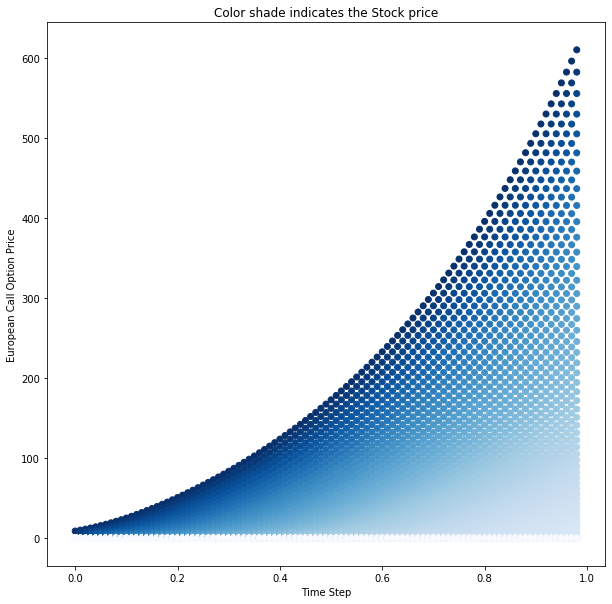

In [110]:
my_option.eur_call_bin_plot(False)


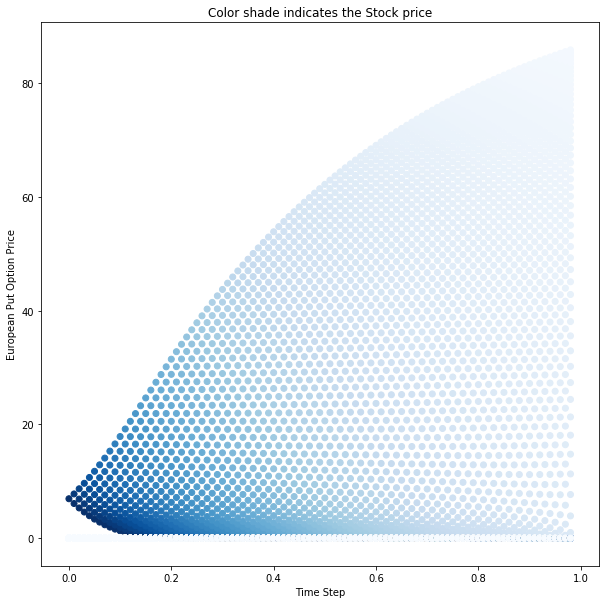

In [111]:
my_option.eur_put_bin_plot(False)

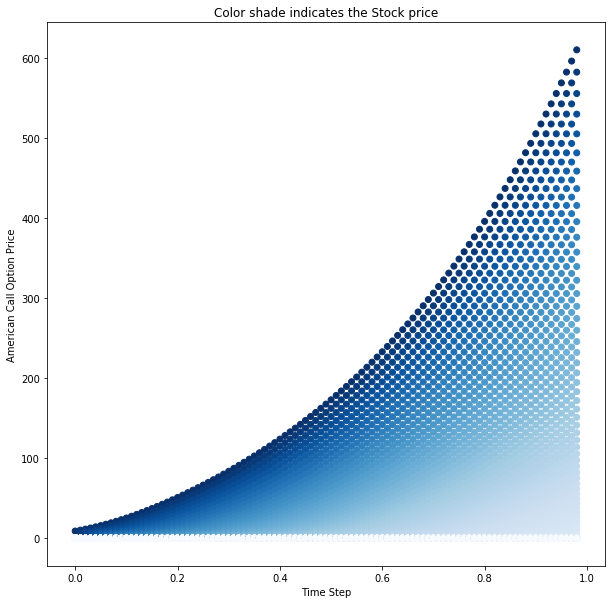

In [112]:
my_option.amer_call_bin_plot(False)

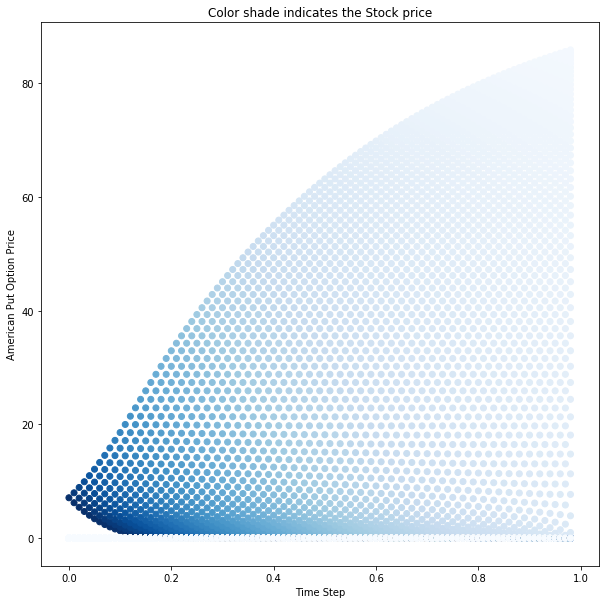

In [113]:
my_option.amer_put_bin_plot(False)

European Option with MonteCarlo simulation

In [114]:
my_option.european_call_MC()

(8.8919561648873, 0.5813713751194882, 0.05398902125364202)

In [115]:
my_option.european_put_MC()

(6.74167182246155, -0.42033014161368953, 0.05398902658271254)

Plot the simulated price paths for MC options pricing

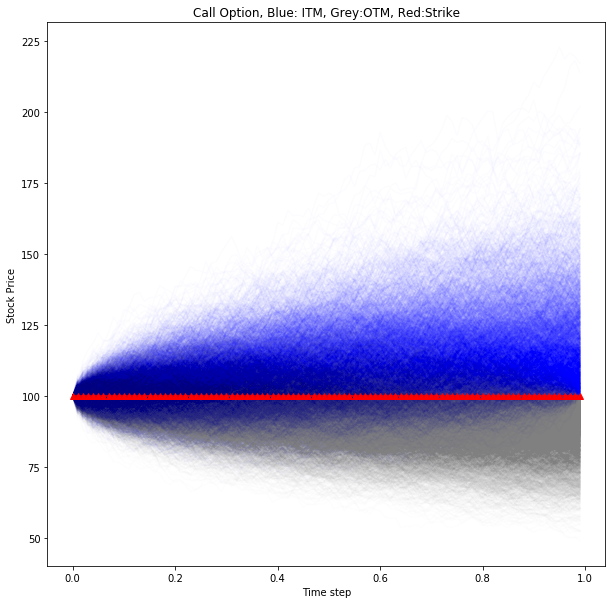

In [116]:
my_option.eur_call_MC_plot()

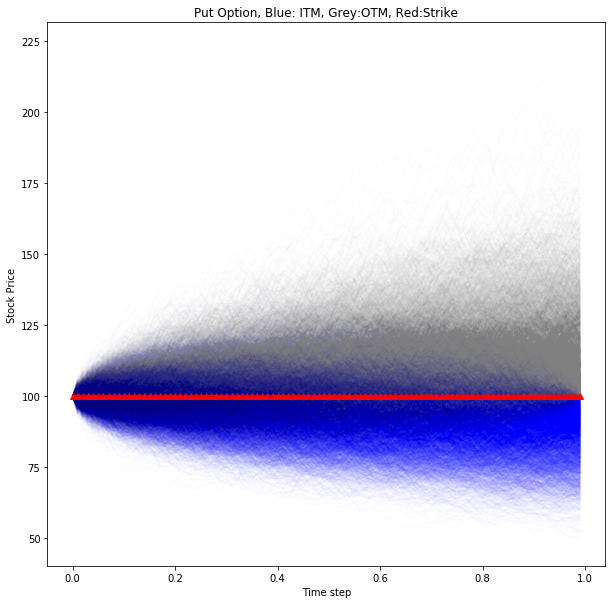

In [117]:
my_option.eur_put_MC_plot()

Plot the option payoff vs. the stock price

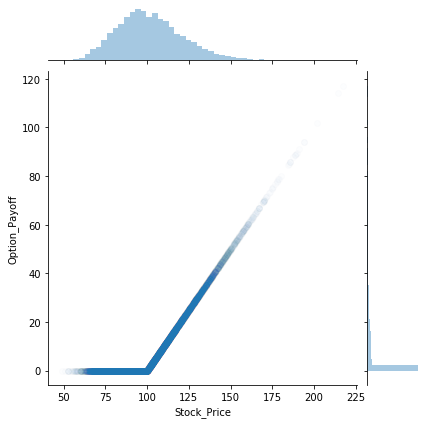

In [118]:
my_option.eur_call_MC_plot(False)

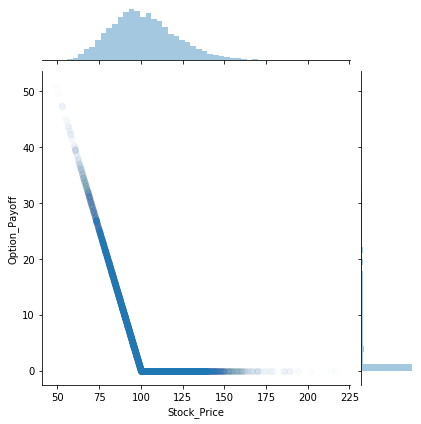

In [119]:
my_option.eur_put_MC_plot(False)

In [291]:
my_option.compare_times()

Black and Scholes call time in seconds: 
0.0003921000006812392
Black and Scholes put time in seconds: 
0.0005604999996648985
